<a href="https://colab.research.google.com/github/boroju/aidl-upc-winter2024-satellite-imagery/blob/main/notebooks/MODIS_fire_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://planetarycomputer.microsoft.com/dataset/modis-14A2-061#Example-Notebook

https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/

https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#Plot-STAC-Items-on-a-Map

https://planetarycomputer.microsoft.com/docs/tutorials/landcover/

https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD14A2

Fires Vs No Fires
https://github.com/aniket-9/COGS-118B/blob/master/data_extraction_nb.ipynb


https://arxiv.org/pdf/2010.07445.pdf

https://github.com/besmehenni/Forest_wildfire_spreading_convLSTM

https://firms.modaps.eosdis.nasa.gov/academy/

https://medium.com/google-earth/how-to-generate-wildfire-boundary-maps-with-earth-engine-b38eadc97a38

https://github.com/UW-GDA/how_GOES_the_fire_detection/tree/main

In [1]:
!pip install odc-stac
!pip install planetary_computer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 796.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 12.7 MB/s eta 0:00:00


In [2]:
import odc.stac
import planetary_computer
import pystac_client
import rich.table

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# 2021 Dixie Wildfire in California
latitude = 40.7310
longitude = -122.9420
location = [longitude, latitude]
geometry = {
    "type": "Point",
    "coordinates": location,
}
datetimes = [
    "2021-07-12",
    "2021-07-20",
    "2021-07-28",
    "2021-08-05",
    "2021-08-13",
    "2021-08-21",
]

buffer = 0.7
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]

In [5]:
stac_items = catalog.search(
    intersects=geometry,
    collections=["modis-14A2-061"],
    datetime="2021-07-12/2021-08-21"
).item_collection()

In [6]:
# stack = stackstac.stack(stac_items, epsg=3857)
# # stack = stackstac.stack(stac_new, epsg=6933, resolution=90, resampling=1, assets=['B01'])
# stack

In [7]:
data = odc.stac.load(
    # items.values(),
    stac_items,
    crs="EPSG:3857",
    bbox=bbox,
    bands="FireMask",
    resolution=1000,
)
data = data.where(data < 10, drop=True)
data

<xarray.Dataset>
Dimensions:      (time: 6, y: 207, x: 157)
Coordinates:
  * y            (y) float64 5.076e+06 5.076e+06 ... 4.872e+06 4.87e+06
  * x            (x) float64 -1.376e+07 -1.376e+07 ... -1.361e+07 -1.361e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-07-12 2021-07-20 ... 2021-08-21
Data variables:
    FireMask     (time, y, x) float32 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0

<ipython-input-8-3d64f822a1e0>:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, datetime in zip(g.axes.flat, datetimes):


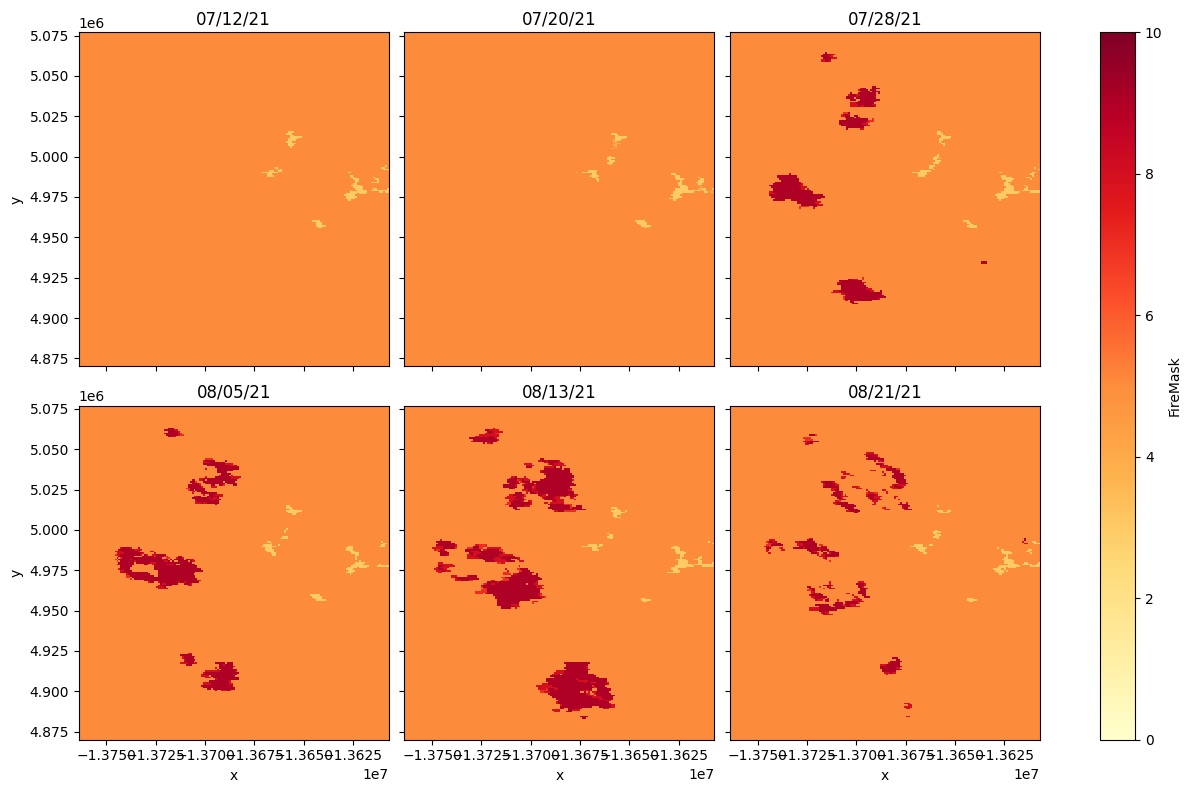

In [8]:
g = data["FireMask"].plot.imshow(
    cmap="YlOrRd", col="time", vmin=0, vmax=10, col_wrap=3, size=4
)

datetimes = data["FireMask"].time.to_pandas().dt.strftime("%D")

for ax, datetime in zip(g.axes.flat, datetimes):
    ax.set_title(datetime)

In [9]:
!pip install geogif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.2.0 which is incompatible.


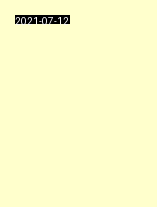

In [10]:
from geogif import gif
gif(data.FireMask, fps=3, cmap="YlOrRd")

## LANDSTAT

https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#Example-Notebook

In [11]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [12]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime="2021-01-01/2021-12-31",
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 99 Items


In [13]:
from pystac.extensions.eo import EOExtension as eo
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LE07_L2SP_045032_20211014_02_T1 from 2021-10-14 with 0.0% cloud cover


In [14]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            lwir: Surface Temperature Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        cloud_qa: Cloud Quality Assessment Band
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Dropped Pixel Quality Assessment Band
   atmos_opacity: 

In [15]:
bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox
).isel(time=0)
data

<xarray.Dataset>
Dimensions:      (y: 5184, x: 3982)
Coordinates:
  * y            (y) float64 4.587e+06 4.587e+06 ... 4.431e+06 4.431e+06
  * x            (x) float64 4.452e+05 4.453e+05 ... 5.646e+05 5.647e+05
    spatial_ref  int32 32610
    time         datetime64[ns] 2021-10-14T17:46:17.961507
Data variables:
    nir08        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    red          (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    green        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    blue         (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    qa_pixel     (y, x) uint16 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    lwir         (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

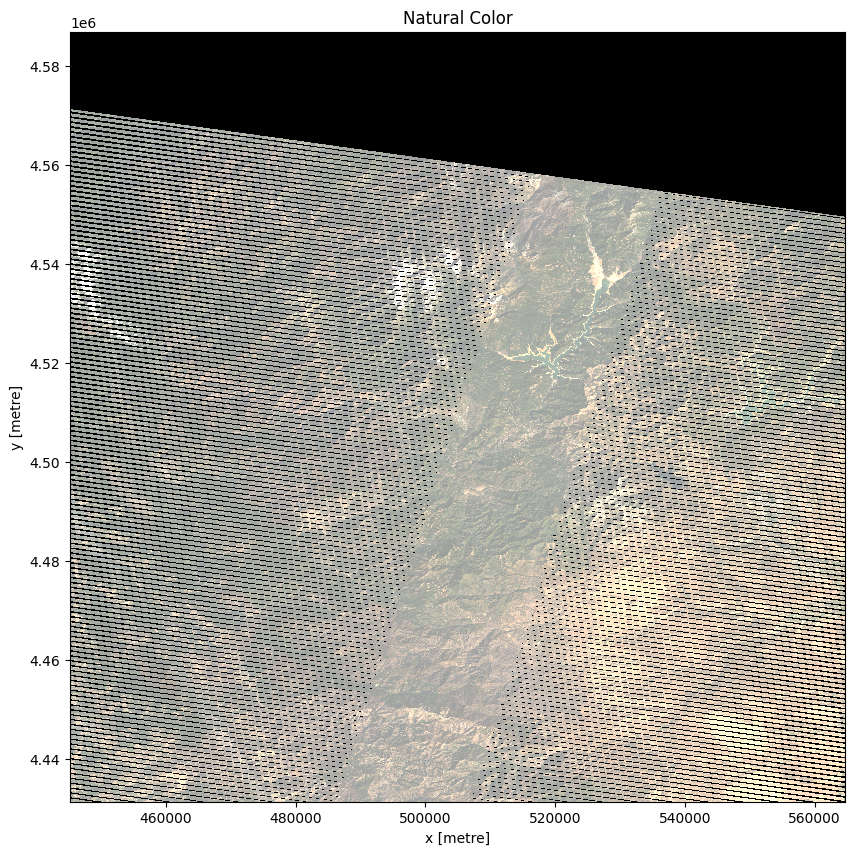

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color");

## MODIS vegetation

https://planetarycomputer.microsoft.com/dataset/modis-13Q1-061#Example-Notebook

In [56]:
def sacramento():
  # Sacramento, CA
  latitude = 38.6
  longitude = -121.5
  buffer = 1
  bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
  return bbox

def dixie():
  # 2021 Dixie Wildfire in California
  latitude = 40.7310
  longitude = -122.9420
  location = [longitude, latitude]
  geometry = {
      "type": "Point",
      "coordinates": location,
  }
  datetimes = [
      "2021-07-12",
      "2021-07-20",
      "2021-07-28",
      "2021-08-05",
      "2021-08-13",
      "2021-08-21",
  ]

  buffer = 0.7
  bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
  return bbox


year = "2021"
months = {
    "January": "01",
    "April": "04",
    "July": "07",
    "October": "10",
}

items = dict()

for name, number in months.items():
    datetime = f"{year}-{number}"
    search = catalog.search(
        collections=["modis-13A1-061"],
        bbox=dixie(),
        datetime=datetime,
    )
    items[name] = search.get_all_items()[0]

print(items)

/usr/local/lib/python3.10/dist-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


{'January': <Item id=MYD13A1.A2021025.h08v05.061.2021042011101>, 'April': <Item id=MOD13A1.A2021113.h08v05.061.2021133131642>, 'July': <Item id=MOD13A1.A2021209.h08v05.061.2021226035904>, 'October': <Item id=MYD13A1.A2021297.h08v05.061.2021314025325>}


In [57]:
item = items["January"]

t = rich.table.Table("Key", "Title")
for key, asset in items["January"].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                                    ┃ Title                                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hdf                                    │ Source data containing all bands                  │
│ metadata                               │ Federal Geographic Data Committee (FGDC) Metadata │
│ 500m_16_days_EVI                       │ 500m 16 days EVI                                  │
│ 500m_16_days_NDVI                      │ 500m 16 days NDVI                                 │
│ 500m_16_days_VI_Quality                │ VI quality indicators                             │
│ 500m_16_days_MIR_reflectance           │ Surface Reflectance Band 7                        │
│ 500m_16_days_NIR_reflectance           │ Surface Reflectance Band 2                        │
│ 500m_16_days_red_reflectance           │ Surface Reflectance Band 1                        │
│ 500m_16_days_blue_reflectance          │ Surface Reflectance Band 3                        │
│ 500m_16_days_sun_zenith_angle          │ Sun zenith angle of VI pixel                      │
│ 500m_16_days_pixel_reliability         │ Quality reliability of VI pixel                   │
│ 500m_16_days_view_zenith_angle         │ View zenith angle of VI Pixel                     │
│ 500m_16_days_relative_azimuth_angle    │ Relative azimuth angle of VI pixel                │
│ 500m_16_days_composite_day_of_the_year │ Day of year VI pixel                              │
│ tilejson                               │ TileJSON with default rendering                   │
│ rendered_preview                       │ Rendered preview                                  │
└────────────────────────────────────────┴───────────────────────────────────────────────────┘

In [58]:
data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bands="500m_16_days_NDVI",
    resolution=500,
    bbox=dixie(),
)

raster = items["January"].assets["500m_16_days_NDVI"].extra_fields["raster:bands"]
data = data["500m_16_days_NDVI"] * raster[0]["scale"]
data

<xarray.DataArray '500m_16_days_NDVI' (time: 4, y: 413, x: 313)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y            (y) float64 5.076e+06 5.076e+06 ... 4.871e+06 4.87e+06
  * x            (x) float64 -1.376e+07 -1.376e+07 ... -1.361e+07 -1.361e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-01-25 2021-04-23 ... 2021-10-24

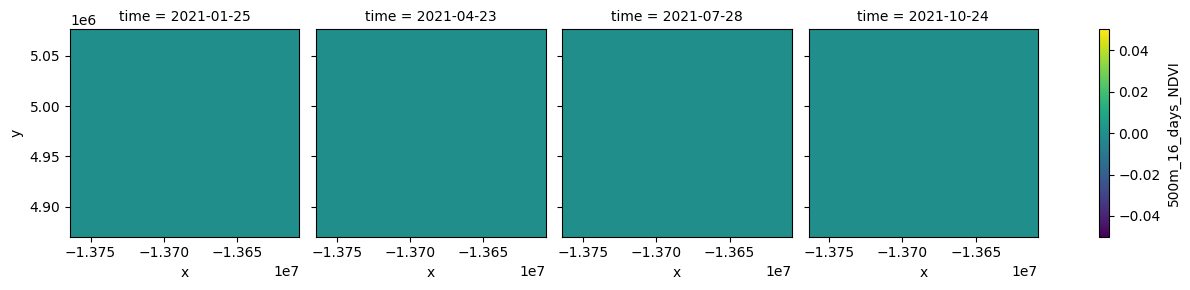

In [59]:
data.plot.imshow(cmap="viridis", col="time");

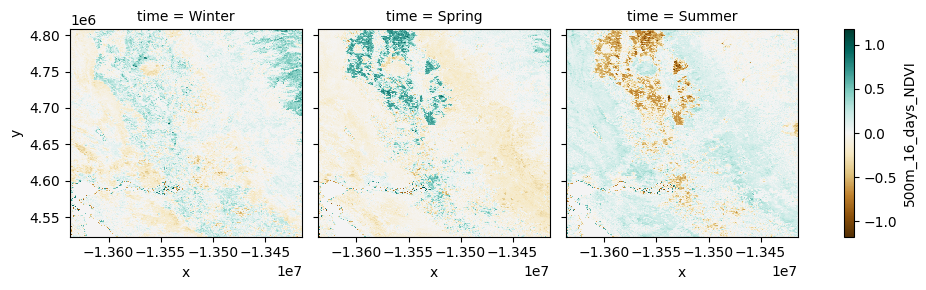

In [55]:
change = data.diff(dim="time").assign_coords(time=["Winter", "Spring", "Summer"])
change.plot.imshow(cmap="BrBG", col="time");

In [22]:
items["January"].assets["500m_16_days_NDVI"]
from IPython.display import Image
Image(url=items["January"].assets["rendered_preview"].href)

https://github.com/microsoft/PlanetaryComputerExamples/blob/main/tutorials/landcover.ipynb

https://planetarycomputer.microsoft.com/dataset/naip#Example-Notebook

In [23]:
#bbox = [-77.9754638671875, 38.58037909468592, -76.37969970703125, 39.812755695478124]
bbox

[-123.642, 40.031, -122.24199999999999, 41.431000000000004]

In [24]:
geometry

{'type': 'Point', 'coordinates': [-122.942, 40.731]}

In [25]:
import pystac_client

api = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")

range_old = "2010-01-01/2013-01-01"
range_new = "2018-01-01/2021-01-01"

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-111.9839859008789, 40.5389819819361],
            [-111.90502166748045, 40.5389819819361],
            [-111.90502166748045, 40.57015381856105],
            [-111.9839859008789, 40.57015381856105],
            [-111.9839859008789, 40.5389819819361],
        ]
    ],
}

search_old = catalog.search(
    collections=["naip"], intersects=area_of_interest, datetime=range_old
)

search_new = catalog.search(
    collections=["naip"], intersects=area_of_interest, datetime=range_new
)


items_old = search_old.item_collection()
items_new = search_new.item_collection()

print(f"{len(items_old)} Items found in the 'old' range")
print(f"{len(items_new)} Items found in the 'new' range")

4 Items found in the 'old' range
4 Items found in the 'new' range


In [26]:
from shapely.geometry import shape

area_shape = shape(area_of_interest)
target_area = area_shape.area


def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area
    return overlap_area / target_area


item_old = sorted(items_old, key=area_of_overlap, reverse=True)[0]
item_new = sorted(items_new, key=area_of_overlap, reverse=True)[0]

In [27]:
from IPython.display import Image

Image(url=item_old.assets["rendered_preview"].href)

In [28]:
Image(url=item_new.assets["rendered_preview"].href)

In [29]:
!pip install rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.6 MB/s eta 0:00:00


In [30]:
import rioxarray

ds = rioxarray.open_rasterio(item_old.assets["image"].href).sel(band=[1, 2, 3])
ds

<xarray.DataArray (band: 3, y: 7630, x: 6000)>
[137340000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 4.15e+05 4.15e+05 4.15e+05 ... 4.209e+05 4.209e+05
  * y            (y) float64 4.491e+06 4.491e+06 ... 4.483e+06 4.483e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [31]:
range_new = "2018-01-01/2021-01-01"

stac_items = catalog.search(
    intersects=geometry,
    collections=["naip"],
    datetime=range_new #"2021-07-12/2021-08-21"
).item_collection()

In [32]:
stac_items

In [33]:

Image(url=stac_items[0].assets["thumbnail"].href)

In [34]:
range_old = "2010-01-01/2013-01-01"
stac_items = catalog.search(
    intersects=geometry,
    collections=["naip"],
    datetime=range_old #"2021-07-12/2021-08-21"
).item_collection()
Image(url=stac_items[0].assets["thumbnail"].href)

In [35]:
print(geometry)

{'type': 'Point', 'coordinates': [-122.942, 40.731]}


In [36]:


query = catalog.search(
    intersects=geometry,
    collections=["naip"],
    datetime=range_old #"2021-07-12/2021-08-21"
)
query.get_items()

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 1 datasets


/usr/local/lib/python3.10/dist-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [37]:
items[0]

<Item id=ca_m_4012217_nw_10_1_20120703_20120904>

In [38]:
asset_href = items[0].assets["data"].href
print(asset_href.split("?")[0])

KeyError: 'data'

In [39]:
#item = items["January"]

t = rich.table.Table("Key", "Title")
for key, asset in items[0].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Title                           ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image            │ RGBIR COG tile                  │
│ metadata         │ FGDC Metdata                    │
│ thumbnail        │ Thumbnail                       │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

In [40]:
(items[0].assets["image"].href)#.sel(band=[1, 2, 3]

'https://naipeuwest.blob.core.windows.net/naip/v002/ca/2012/ca_100cm_2012/40122/m_4012217_nw_10_1_20120703.tif?st=2024-01-07T21%3A35%3A44Z&se=2024-01-08T22%3A20%3A44Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-01-08T19%3A37%3A59Z&ske=2024-01-15T19%3A37%3A59Z&sks=b&skv=2021-06-08&sig=5vpEslkcKE7Q/6UkSCEMg4PxBKvI7JX8V83VdxuCTO8%3D'

In [41]:
import rioxarray

ds = rioxarray.open_rasterio(items[0].assets["image"].href).sel(band=[1, 2, 3])
ds

<xarray.DataArray (band: 3, y: 7570, x: 5910)>
[134216100 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 4.997e+05 4.997e+05 ... 5.056e+05 5.056e+05
  * y            (y) float64 4.511e+06 4.511e+06 ... 4.504e+06 4.504e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [42]:
ds.sel(band=[1, 2, 3])

<xarray.DataArray (band: 3, y: 7570, x: 5910)>
[134216100 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 4.997e+05 4.997e+05 ... 5.056e+05 5.056e+05
  * y            (y) float64 4.511e+06 4.511e+06 ... 4.504e+06 4.504e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

https://github.com/microsoft/PlanetaryComputerExamples/blob/main/tutorials/landcover.ipynb

In [43]:
!pip install hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.2 MB/s eta 0:00:00


In [44]:
!pip install datashader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 41.1 MB/s eta 0:00:00


In [45]:
from bokeh.models.tools import BoxZoomTool
zoom = BoxZoomTool(match_aspect=True)
style_kwargs = dict(
    width=450,
    height=400,
    xaxis=False,
    yaxis=False,
)
kwargs = dict(
    x="x",
    y="y",
   # cmap=cmap,
    rasterize=True,
    aggregator="mode",
    colorbar=False,
    tools=["pan", zoom, "wheel_zoom", "reset"],
    clim=(0, 12),
)

In [46]:
import hvplot.xarray
image_2013_plot = (
    ds.sel(band=[1, 2, 3])
    .hvplot.rgb(
        bands="band",
        x="x",
        y="y",
        rasterize=True,
        title="NAIP 2013",
        hover=False,
        **style_kwargs,
    )
    .opts(default_tools=[])
)

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

In [47]:
import panel
panel.GridBox(
    image_2013_plot)

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

GridBox
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=450)

In [48]:
query.items()

data = odc.stac.load(
    query.items(),
    bands=["red", "green", "blue"],
    resolution=100,
)

KeyError: ('image', 2)

In [ ]:
data = odc.stac.load(
    # items.values(),
    stac_items,
    crs="EPSG:3857",
    bbox=bbox,
    bands="FireMask",
    resolution=1000,
)
data = data.where(data < 10, drop=True)
data

In [ ]:
# catalog = pystac_client.Client.open(...)
# query = catalog.search(...)
data = odc.stac.load(
    query.get_items(),
    bands=["red", "green", "blue"],
    resolution=100,
)
data.red.plot.imshow(col="time")

In [ ]:
https://planetarycomputer.microsoft.com/dataset/drcog-lulc#Example-Notebook

https://planetarycomputer.microsoft.com/dataset/drcog-lulc#Example-Notebook